In [1]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [2]:
import numpy as np
import cv2
import os
from scipy.spatial.distance import cdist
from keypointDetect import DoGdetector

import matplotlib.pyplot as plt

# Interest Points

Before finding the homography between an image pair, we need to find corresponding point pairs between two images. But how do we get these points? One way is to select them manually (using `cpselect`), which is tedious and inefficient. The CV way is to find interest points in the image pair and automatically match them. In the interest of being able to do cool stuff, we will not re-implement a feature detector here, but use built-in methods. The purpose of an interest point detector (e.g. Harris, FAST, SIFT, SURF, etc.) is to find particular salient points in the images around which we extract feature descriptors (e.g. BRIEF, ORB, etc.). These descriptors try to summarize the content of the image around the feature points in as succinct yet descriptive manner possible (there is often a trade-off between representational and computational complexity for many computer vision tasks; you can have a very high dimensional feature descriptor that would ensure that you get good matches, but computing it could be prohibitively expensive). Matching, then, is a task of trying to find a descriptor in the list of descriptors obtained after computing them on a new image that best matches the current descriptor. This could be something as simple as the Euclidean distance between the two descriptors, or something more complicated, depending on how the descriptor is composed. 

For the purpose of this exercise, you can use FAST or Harris detector in concert with the BRIEF descriptor. You can use Python functions [skimage.feature](http://scikit-image.org/docs/0.13.x/api/skimage.feature.html) such as [skimage.feature.corner_harris](http://scikit-image.org/docs/0.13.x/api/skimage.feature.htm#skimage.feature.corner_harris) or [skimage.feature.corner_fast](http://scikit-image.org/docs/0.13.x/api/skimage.feature.html#skimage.feature.corner_fast).


## Question 2: BRIEF Descriptor (25 points)

Now that we have interest points that tell us where to find the most informative
points in the image, we can compute descriptors that can be used to match to
other views of the same point in different images. The BRIEF descriptor encodes
information from a $9\times9$ patch $p$ centered around the interest point at
the _characteristic scale_ of the interest point. See the lecture notes for
Point Feature Detectors if you need to refresh your memory.

### 2.1 Creating a Set of BRIEF Tests (5 pts)

The descriptor itself is a vector that is $n$-bits long, where each bit is the
result of the following simple test:

\begin{equation}
  \tau(p;x,y):=\begin{cases}
    1, & \text{if $p(x)<p(y)$}.\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}
Set $n$ to 256 bits. There is no need to encode the test results as actual bits. It is fine to encode them as a 256 element vector.

There are many choices for the 256 test pairs $(x,y)$ used to compute
$\tau(p;x,y)$ (each of the $n$ bits). The authors describe and test
some of them in [the BRIEF paper](https://link.springer.com/content/pdf/10.1007/978-3-642-15561-1_56.pdf). Read section 3.2 of that paper and implement
one of these solutions. You should generate a static set of test pairs and save
that data to a file. You will use these pairs for all subsequent computations of
the BRIEF descriptor. 
&nbsp;


#### Q 2.1

Write the function to create the $x$ and $y$
pairs that we will use for comparison to compute $\tau$:

\begin{equation}
    {\tt [compareX, compareY] = makeTestPattern(patchWidth, nbits) }
\end{equation}

${\tt patchWidth }$ is the width of the image patch (usually $9$) and ${\tt nbits }$
is the number of tests $n$ in the BRIEF descriptor. ${\tt compareX }$ and
${\tt compareY }$ are are each $nbits\times 1$ vectors linear indices, and the indice values are in $[0, {\texttt{patchWidth} \times \texttt{patchWidth}})$. Run this
routine for the given parameters $\texttt{patchWidth}=9$ and $n=256$ and save
the results in ${\tt testPattern.npy }$. **Include this file** in your submission.


In [3]:
def makeTestPattern(patch_width=9, nbits=256):
    '''
    Creates Test Pattern for BRIEF.
    Run this routine for the given parameters patch_width = 9 and n = 256.

    INPUTS
    patch_width - the width of the image patch (usually 9)
    nbits      - the number of tests n in the BRIEF descriptor

    OUTPUTS
    compareX and compareY - LINEAR indices into the patch_width x patch_width image 
                            patch and are each (nbits,) vectors. 
    '''
    # Hint: Technically, you can use any patterns you want, as long as all the images
    # use the same pattern.  Random indices could be a solution.
      
    np.random.seed(0)
    compareX = np.random.randint(0, patch_width ** 2, size=(nbits, 1))
    compareY = np.random.randint(0, patch_width ** 2, size=(nbits, 1))
    
    np.save('data/testPattern.npy', [compareX, compareY])
    return  compareX, compareY

In [4]:
### HIDDEN TEST CELL
# Hint: We will check the existance of the file and the shape of the
# indice vectors. Do not modify the following parameters
compareX, compareY = makeTestPattern(patch_width=9, nbits=256)
# change the following path to where you save the file
test_pattern_file = 'data/testPattern.npy'

### 2.2 Compute the BRIEF Descriptor (5 pts) 

#### Q 2.2 

It is now time to compute the BRIEF descriptor for the detected keypoints.  We need a function similar to the following one to do this:

\begin{equation}
{\tt [locs,desc] = computeBrief(im, locs, compareX, compareY)}
\end{equation}

Where $\texttt{im}$ is a grayscale image with values from 0 to 1, $\texttt{locs}$ are the keypoint
locations returned by a keypoint detector. ${\tt
compareX}$ and ${\tt compareY}$ are the test patterns computed in
Section 2.1 and were saved into ${\tt testPattern.npy}$.

In this problem, you are going to use the provided $\texttt{DoGdetector}$ function to detect keypoints. This function returns two outputs: The first one is ${\tt locsDoG}$, $(m, 3)$, where the first two columns are the image coordinates of keypoints and the last column is the Gaussian pyramid levels from which the keypoints were detected. The second output is ${\tt gaussPyramid}$, $(h, w, l)$, where $(h, w)$ is the image dimension and $l$ is the number of levels. Instead of using $\texttt{im}$ as the input of ${\tt computeBrief()}$, we are going to use ${\tt gaussPyramid}$ in this problem:

\begin{equation}
{\tt [locs,desc] = computeBrief(gaussPyramid, locsDoG, compareX, compareY)}
\end{equation}

For computing the BRIEF of a keypoint, you can first identify the level of this keypoint using the last column of ${\tt locsDoG}$, and then compute the BRIEF using the image patch from that level of the Gaussian pyramid.

The function returns ${\tt locs}$, an $m \times 2$ vector, where the two
columns are the image coordinates of keypoints, and ${\tt desc}$, an $m \times n \space{ } bits$ matrix of
stacked BRIEF descriptors. $m$ is the number of valid descriptors in the image
and will vary. $n$ is the number of bits for the BRIEF descriptor. You may have to be careful about the input detector locations
since they may be at the edge of an image where we cannot extract a full patch
of width $\texttt{patchWidth}$. Thus, the number of output $\texttt{locs}$ may be
less than the input.

In [5]:
def computeBrief(gaussPyramid, locsDoG, compareX, compareY, patch_width=9):
    '''
    Compute Brief feature
     INPUT
     gaussPyramid - the input Gaussian pyramid, (h, w, l).
     locsDoG - the keypoints detected by the DOGDetector, (m, 3).
     compareX and compareY - linear indices into the 
                             (patch_width x patch_width) image patch and are
                             each (nbits, 1) vectors.
                            
     OUTPUT
     newlocs - an m x 2 vector, where the two columns are the image
    		 coordinates of keypoints. Note this is required as x, y (col, row)
     desc - an m x n bits matrix of stacked BRIEF descriptors. m is the number
            of valid descriptors in the image.
    '''
    # Hint: you need to:
    #  1) Remove those invalid locations (close to the image edges);
    #  2) Compute the BRIEF feature for those valid keypoints.
    # YOUR CODE HERE
    
    left_limit = patch_width // 2
    right_limit_h = gaussPyramid.shape[0] - patch_width // 2
    right_limit_w = gaussPyramid.shape[1] - patch_width // 2
    
    valid_locsDoG = locsDoG[np.logical_and(np.logical_and(locsDoG[:, 0] > left_limit,
                                                          locsDoG[:, 0] < right_limit_h),
                                           np.logical_and(locsDoG[:, 1] > left_limit,                                                           
                                                          locsDoG[:, 1] < right_limit_w))]
    
    desc = []
    
    for i in range(valid_locsDoG.shape[0]):
        patch = gaussPyramid[valid_locsDoG[i, 0] - patch_width // 2: valid_locsDoG[i, 0] + patch_width // 2 + 1,
                             valid_locsDoG[i, 1] - patch_width // 2: valid_locsDoG[i, 1] + patch_width // 2 + 1,
                             valid_locsDoG[i, 2]]
        patch = patch.flatten()
        tau = patch[compareX] < patch[compareY]
        desc.append(list(map(lambda j: str(int(tau[j])), range(len(tau)))))        
            
#     newlocs = valid_locsDoG[:,: 2]
    newlocs = valid_locsDoG[:, -2: -4: -1]
    desc = np.stack(desc)
    
#     print(f'{locsDoG.shape = }')
#     print(f'{newlocs.shape = }')
#     print(f'{compareX.shape = }')
#     print(f'{compareY.shape = }')
#     print(f'{desc.shape = }')
    
    
#     print(f'{np.min(locsDoG[:, 0]) = }')
#     print(f'{np.max(locsDoG[:, 0]) = }')
#     print(f'{np.min(locsDoG[:, 1]) = }')
#     print(f'{np.max(locsDoG[:, 1]) = }')
#     print(f'{np.min(newlocs[:, 0]) = }')
#     print(f'{np.max(newlocs[:, 0]) = }')
#     print(f'{np.min(newlocs[:, 1]) = }')
#     print(f'{np.max(newlocs[:, 1]) = }')
    
    return newlocs, desc

In [6]:
### HIDDEN TEST CELL
# Hint: We will use the 'pf_scan_scaled.jpg' for this test.
# The output "newlocs" and "desc" should have the same first dimension.

### 2.3 Putting it all Together (5 pts)

#### Q 2.3

Write a function :

\begin{equation}
{\tt [locs, desc] = briefLite(im)}
\end{equation}
which accepts a grayscale image ${\tt im}$ with values between zero and one and
returns ${\tt locs}$, an $m \times 2$ vector, where the two columns are the
image coordinates of keypoints, and ${\tt desc}$, an $m \times n~bits$ matrix of stacked BRIEF
descriptors. $m$ is the number of valid descriptors in the image and will vary.
$n$ is the number of bits for the BRIEF descriptor.

This function should perform all the necessary steps to extract the descriptors from the image, including
   - Load parameters and test patterns
   - Get keypoint locations
   - Compute a set of valid BRIEF descriptors

In [7]:
def briefLite(im):
    '''
    Given an image, detect the keypoints and describe the keypoints with descriptors.
    
    INPUTS
        im - gray image with values between 0 and 1
    OUTPUTS
        locs - an m x 3 vector, where the first two columns are the image coordinates 
                of keypoints and the third column is the pyramid level of the keypoints
        desc - an m x n bits matrix of stacked BRIEF descriptors. 
                m is the number of valid descriptors in the image and will vary
                n is the number of bits for the BRIEF descriptor
    '''
    # Hint: Use the provided "DoGdetector()" obtain the smoothed Gaussian pyramid and
    # the keypoints, and use them as the input of "computeBrief()"
    
    locsDoG, gauss_pyramid = DoGdetector(im)
    [compareX, compareY] = np.load('data/testPattern.npy')
    
    locs, desc = computeBrief(gauss_pyramid, locsDoG, compareX, compareY)
    
    return locs, desc

In [8]:
### HIDDEN TEST CELL
# Hint: We will use the 'pf_scan_scaled.jpg' for this test.
# The output "newlocs" and "desc" should have the same first dimension.

### 2.4 Check Point: Descriptor Matching (5 pts)

A descriptor's strength is in its ability to match to other descriptors
generated by the same world point, despite change of view, lighting, etc. The
distance metric used to compute the similarity between two descriptors is
critical. For BRIEF, this distance metric is the Hamming distance. The Hamming
distance is simply the number of bits in two descriptors that differ. (Note that
the position of the bits matters.)  


To perform the descriptor matching mentioned above, we have provided the function:

\begin{equation}
{\tt [matches] = briefMatch(desc1, desc2, ratio)}
\end{equation}

Which accepts an $m_1 \times n~bits$ stack of BRIEF descriptors from a first image
and a $m_2 \times n~bits$ stack of BRIEF descriptors from a second image and
returns a $p \times 2$ matrix of matches, where the first column are indices
into ${\tt desc1}$ and the second column are indices into ${\tt desc2}$. Note that
$m_1$, $m_2$, and $p$ may be different sizes and $p \leq \text{min}\left(
m_1,m_2
\right)$.

For a better visual understanding of the result, we have provided a function for
you to plot the matched keypoint correspondences:

\begin{equation}
{\tt plotMatches(im1, im2, matches, locs1, locs2)}
\end{equation}

where ${\tt im1}$ and ${\tt im2}$ are grayscale images from $0$ to $1$,
$\texttt{matches}$ is the list of matches returned by ${\tt briefMatch}$ and ${\tt
locs1}$ and ${\tt locs2}$ are the locations of keypoints from ${\tt briefLite}$.  

#### Q 2.4

Write a test script ${\tt testMatch}$ to load
two of the $\textit{chickenbroth}$ images, compute feature matches.

**This problem will be manually graded.** Save the resulting figure and submit it in your PDF. Briefly discuss any cases that perform worse or better.

Fig 2.1 is an example result.  
_Suggest for debugging: A good test of your code is to
check that you can match an image to itself._

|<img align="center" src="figure/matches.png" width="500">|
|:--:|
|Fig 2.1 Example of BRIEF matches for model chickenbroth.jpg and chickenbroth\_01.jpg.|

In [9]:
def briefMatch(desc1, desc2, ratio=0.8):
    '''
    Performs the descriptor matching.
    
    INPUTS
        desc1 , desc2 - m1 x n and m2 x n matrix. m1 and m2 are the number of keypoints in
                        image 1 and 2. n is the number of bits in the brief
    OUTPUT
        matches - p x 2 matrix. where the first column are indices
                  into desc1 and the second column are indices into desc2
    '''
    D = cdist(np.float32(desc1), np.float32(desc2), metric='hamming')
    # find the smallest distance
    ix2 = np.argmin(D, axis=1)
    d1 = D.min(1)
    # find the second smallest distance
    d12 = np.partition(D, 2, axis=1)[:,0:2]
    d2 = d12.max(1)
    r = d1/(d2+1e-10)
    is_discr = r<ratio
    ix2 = ix2[is_discr]
    ix1 = np.arange(D.shape[0])[is_discr]
    matches = np.stack((ix1,ix2), axis=-1)
    return matches

def plotMatches(im1, im2, matches, locs1, locs2):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    im[0:im1.shape[0], 0:im1.shape[1]] = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im[0:im2.shape[0], im1.shape[1]:] = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    plt.imshow(im, cmap='gray')
    for i in range(matches.shape[0]):
        pt1 = locs1[matches[i,0], 0:2]
        pt2 = locs2[matches[i,1], 0:2].copy()
        pt2[0] += im1.shape[1]
        x = np.asarray([pt1[0], pt2[0]])
        y = np.asarray([pt1[1], pt2[1]])
        plt.plot(x,y,'r')
        plt.plot(x,y,'g.')
    plt.show()

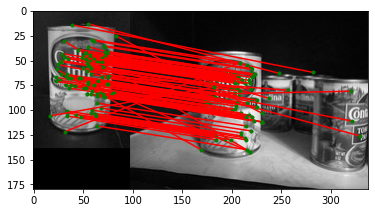

In [10]:
img1 = cv2.imread('data/model_chickenbroth.jpg')
# img1 = cv2.imread('data/chickenbroth_01.jpg')
locs1, desc1 = briefLite(img1)

img2 = cv2.imread('data/chickenbroth_01.jpg')
locs2, desc2 = briefLite(img2)

matches = briefMatch(desc1, desc2)
plotMatches(img1, img2, matches, locs1, locs2)

### 2.5 BRIEF and rotations (5 pts)

You may have noticed worse performance under rotations. Let's investigate this!

#### Q 2.5

Take the $\texttt{model_chickenbroth.jpg}$
test image and match it to itself while rotating the second image (hint:
$\texttt{imrotate}$) in increments of 10 degrees. Count the number of correct
matches at each rotation and construct a bar graph showing rotation angle vs the
number of correct matches.  

**This problem will be manually graded.** Include your code and the historgram figure in your PDF, and explain why you think  the descriptor behaves this way.

213 213
37 37


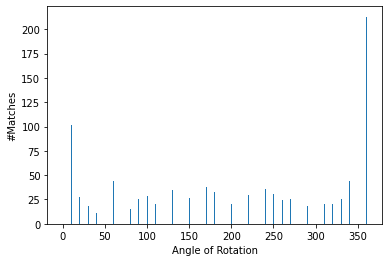

In [18]:
# from skimage.transform import rotate

img1 = cv2.imread('data/model_chickenbroth.jpg')
locs1, desc1 = briefLite(img1)

img2 = cv2.imread('data/model_chickenbroth.jpg')   
h, w, _ = img2.shape

counts = []

for i in range(0, 370, 10):
    
    # could've just used this matrix again and again. However, the img2 quality is getting worse
    # so, matches are reducing.
    M = cv2.getRotationMatrix2D((w / 2, h / 2), i, 1.0)
    rotated = cv2.warpAffine(img2, M, (w, h))    
    locs2, desc2 = briefLite(rotated)
    matches = briefMatch(desc1, desc2)
    
    counts.append(len(matches))

print(counts[0], counts[-1])
    
print(len(list(range(0, 370, 10))), len(counts))
plt.bar(list(range(0, 370, 10)), counts, align='edge')
plt.xlabel('Angle of Rotation')
plt.ylabel('#Matches')
plt.show()

### 2.6 Improving Performance - (Extra Credit, 10 pts)

The extra credit opportunities described below are optional and provide an
avenue to explore computer vision and improve the performance of the techniques developed above.

**This problem will be manually graded.**

   1. ($\textbf{5 pts}$) As we have seen, BRIEF is not rotation invariant. Design a simple fix to solve this problem using the tools you have developed so far (think back to edge detection and/or Harris corner's covariance matrix).  Include the code in your PDF, and explain your design decisions and how you selected any parameters that you use. Demonstrate the effectiveness of your algorithm on image pairs related by large rotation.

   2. ($\textbf{5 pts}$) This implementation of BRIEF has some scale invariance, but there are limits.  What happens when you match a picture to the same picture at half the size?  Look to section 3 of [Lowe2004](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for a technique that will make your detector more robust to changes in scale. Implement it and demonstrate it in action with several test images. Include yout code and the test images in your PDF. You may simply rescale some of the test images we have given you. 

In [25]:
def computeRBrief(gaussPyramid, locsDoG, compareX, compareY, patch_width=9):
    
    h, w, _ = gaussPyramid.shape
    left_limit = patch_width // 2
    right_limit_h = gaussPyramid.shape[0] - patch_width // 2
    right_limit_w = gaussPyramid.shape[1] - patch_width // 2
    
    valid_locsDoG = locsDoG[np.logical_and(np.logical_and(locsDoG[:, 0] > left_limit,
                                                          locsDoG[:, 0] < right_limit_h),
                                           np.logical_and(locsDoG[:, 1] > left_limit,                                                           
                                                          locsDoG[:, 1] < right_limit_w))]
    
    desc = []
    
    for i in range(valid_locsDoG.shape[0]):
        patch = gaussPyramid[valid_locsDoG[i, 0] - patch_width // 2: valid_locsDoG[i, 0] + patch_width // 2 + 1,
                             valid_locsDoG[i, 1] - patch_width // 2: valid_locsDoG[i, 1] + patch_width // 2 + 1,
                             valid_locsDoG[i, 2]]
        
#         patch = patch.flatten()
        m10 = np.sum(np.repeat(np.arange(valid_locsDoG[i, 0] - patch_width // 2,
                                         valid_locsDoG[i, 0] + patch_width // 2 + 1).reshape(1, -1),
                               patch_width, axis=0) * patch)
        m01 = np.sum(np.repeat(np.arange(valid_locsDoG[i, 1] - patch_width // 2,
                                         valid_locsDoG[i, 1] + patch_width // 2 + 1).reshape(1, -1),
                               patch_width, axis=0) * patch)
        m00 = np.sum(patch)
        theta = - np.arctan2(m01, m10)
        R = np.array([[np.cos(theta), - np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        
#         print(R.shape)
#         print(np.stack((compareX.flatten(), compareY.flatten())).shape)
        
        compareMat = np.int32(R @ np.stack((compareX.flatten(), compareY.flatten())))
        
        tau = gaussPyramid[(int(valid_locsDoG[i, 0] - patch_width // 2) + compareMat[0].flatten() // patch_width).clip(0, h - 1),
                           (int(valid_locsDoG[i, 1] - patch_width // 2) + compareMat[0].flatten() % patch_width).clip(0, w - 1),
                           valid_locsDoG[i, 2]] < \
              gaussPyramid[(int(valid_locsDoG[i, 0] - patch_width // 2) + compareMat[1].flatten() // patch_width).clip(0, h - 1),
                           (int(valid_locsDoG[i, 1] - patch_width // 2) + compareMat[1].flatten() % patch_width).clip(0, w - 1),
                           valid_locsDoG[i, 2]]
        desc.append(list(map(lambda j: str(int(tau[j])), range(len(tau)))))        
            
    newlocs = valid_locsDoG[:, -2: -4: -1]
    desc = np.stack(desc)
    
    return newlocs, desc

In [28]:
def rBriefLite(im):
    '''
    Given an image, detect the keypoints and describe the keypoints with descriptors.
    
    INPUTS
        im - gray image with values between 0 and 1
    OUTPUTS
        locs - an m x 3 vector, where the first two columns are the image coordinates 
                of keypoints and the third column is the pyramid level of the keypoints
        desc - an m x n bits matrix of stacked BRIEF descriptors. 
                m is the number of valid descriptors in the image and will vary
                n is the number of bits for the BRIEF descriptor
    '''
    # Hint: Use the provided "DoGdetector()" obtain the smoothed Gaussian pyramid and
    # the keypoints, and use them as the input of "computeBrief()"
    
    locsDoG, gauss_pyramid = DoGdetector(im)
    [compareX, compareY] = np.load('data/testPattern.npy')
    
    locs, desc = computeRBrief(gauss_pyramid, locsDoG, compareX, compareY)
    
    return locs, desc

/home/punit13/personal/fall21/16720/assignments/hw4/keypointDetect.py:87: RuntimeWarning: divide by zero encountered in true_divide
  principal_curvature = np.divide(np.square(np.add(gxx, gyy)), (np.multiply(gxx, gyy) - np.multiply(gxy, gyx)))
/home/punit13/personal/fall21/16720/assignments/hw4/keypointDetect.py:87: RuntimeWarning: invalid value encountered in true_divide
  principal_curvature = np.divide(np.square(np.add(gxx, gyy)), (np.multiply(gxx, gyy) - np.multiply(gxy, gyx)))


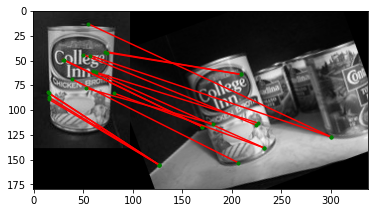

In [30]:
img1 = cv2.imread('data/model_chickenbroth.jpg')
# img1 = cv2.imread('data/chickenbroth_01.jpg')
locs1, desc1 = rBriefLite(img1)

img2 = cv2.imread('data/chickenbroth_01.jpg')

h, w, _ = img2.shape

M = cv2.getRotationMatrix2D((w / 2, h / 2), 20, 1.0)
rotated = cv2.warpAffine(img2, M, (w, h)) 
locs2, desc2 = rBriefLite(rotated)  

matches = briefMatch(desc1, desc2)
plotMatches(img1, rotated, matches, locs1, locs2)